<a href="https://colab.research.google.com/github/rizaho/ml_for_financial_analysis/blob/main/201_4_FACEBOOK_PROPHET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PROPHET (FACEBOOK)

https://thedatahero.com/resources-forecasting-models-and-time-series-for-business-in-python/

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from google.colab import drive
import seaborn as sns
%matplotlib inline
from copy import copy
from scipy import stats
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go
import math
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from statsmodels.graphics.tsaplots import month_plot, quarter_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # auto correlation, partial auto-correlation
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing
from sklearn.model_selection import ParameterGrid

# facebook prophet
from prophet import Prophet
from prophet.utilities import regressor_coefficients
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_cross_validation_metric

# runtime settings
import sys
#np.set_printoptions(threshold=sys.maxsize)

## mount drive

In [59]:
# read data from google drive
drive.mount('/content/drive')
DATA_ROOT_PATH = "Python-Time-Series-Forecasting"
# /content/drive/MyDrive/Colab Notebooks/Python-Time-Series-Forecasting/Modern Time Series Forecasting Techniques/Prophet
DATA_SUB_INTRO = "Modern Time Series Forecasting Techniques/Prophet"
DRIVE_DATASET_PATH = "/content/drive/My Drive/Colab Notebooks/" + DATA_ROOT_PATH + "/" + DATA_SUB_INTRO + "/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [60]:
%ls

drive/  sample_data/


In [61]:
# Daily Bike Sharing training.csv
df = pd.read_csv(DRIVE_DATASET_PATH + "Daily Bike Sharing training.csv")
df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,1/1/2011,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,1/2/2011,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,1/3/2011,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,1/4/2011,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,1/5/2011,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


# Preparing Data

In [62]:
# rename columns
df = df.rename(columns = {
    "cnt": "y",
    "dteday": "ds"
    })

# Change ds into YYYY-mm-dd
df["ds"] = pd.to_datetime(df["ds"], format="%m/%d/%Y")

df.head()

,instant,ds,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,y
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


In [63]:
# Prepare the weather situation, make it categorical

weather_sit = pd.get_dummies(df["weathersit"], drop_first = True)
weather_sit

# concat weather_sit to df
df = pd.concat([df, weather_sit], axis = 1)
df.head()

,instant,ds,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,y,2,3
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985,True,False
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801,True,False
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349,False,False
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562,False,False
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600,False,False


In [64]:
# rename new columns named, 2 and 3
df = df.rename(columns = {
    2: "weathersit_2",
    3: "weathersit_3"
    })
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 701 entries, 0 to 700
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   instant       701 non-null    int64         
 1   ds            701 non-null    datetime64[ns]
 2   season        701 non-null    int64         
 3   yr            701 non-null    int64         
 4   mnth          701 non-null    int64         
 5   holiday       701 non-null    int64         
 6   weekday       701 non-null    int64         
 7   workingday    701 non-null    int64         
 8   weathersit    701 non-null    int64         
 9   temp          701 non-null    float64       
 10  atemp         701 non-null    float64       
 11  hum           701 non-null    float64       
 12  windspeed     701 non-null    float64       
 13  casual        701 non-null    int64         
 14  registered    701 non-null    int64         
 15  y             701 non-null    int64     

In [65]:
# Drop variables that are not needed
df.drop(
    columns = ["instant", "season", "yr", "mnth", "weekday", "casual", "registered"],
        axis = 1,
        inplace = True)
df.head()


,ds,holiday,workingday,weathersit,temp,atemp,hum,windspeed,y,weathersit_2,weathersit_3
0,2011-01-01,0,0,2,0.344167,0.363625,0.805833,0.160446,985,True,False
1,2011-01-02,0,0,2,0.363478,0.353739,0.696087,0.248539,801,True,False
2,2011-01-03,0,1,1,0.196364,0.189405,0.437273,0.248309,1349,False,False
3,2011-01-04,0,1,1,0.200000,0.212122,0.590435,0.160296,1562,False,False
4,2011-01-05,0,1,1,0.226957,0.229270,0.436957,0.186900,1600,False,False


In [66]:
# lets replace this outlier data with something.
# 2012-10-29 and 2012-10-30 --> 2012-10-28
# ref: on the 2012-10-29 in Washington DC


In [67]:
to_replace = df.loc[df.ds == "2012-10-28"].y.values[0]
df.loc[df.ds == "2012-10-29", "y"] = to_replace
df.loc[df.ds == "2012-10-28", "y"] = to_replace


# EDA

In [68]:
# Create a copy of the df with index
df_temp = df.copy()
df_temp.set_index("ds", inplace = True)
df_temp.head()

,holiday,workingday,weathersit,temp,atemp,hum,windspeed,y,weathersit_2,weathersit_3
ds,,,,,,,,,,
2011-01-01,0,0,2,0.344167,0.363625,0.805833,0.160446,985,True,False
2011-01-02,0,0,2,0.363478,0.353739,0.696087,0.248539,801,True,False
2011-01-03,0,1,1,0.196364,0.189405,0.437273,0.248309,1349,False,False
2011-01-04,0,1,1,0.200000,0.212122,0.590435,0.160296,1562,False,False
2011-01-05,0,1,1,0.226957,0.229270,0.436957,0.186900,1600,False,False


In [69]:
df_temp.index
# freq = None

DatetimeIndex(['2011-01-01', '2011-01-02', '2011-01-03', '2011-01-04',
               '2011-01-05', '2011-01-06', '2011-01-07', '2011-01-08',
               '2011-01-09', '2011-01-10',
               ...
               '2012-11-22', '2012-11-23', '2012-11-24', '2012-11-25',
               '2012-11-26', '2012-11-27', '2012-11-28', '2012-11-29',
               '2012-11-30', '2012-12-01'],
              dtype='datetime64[ns]', name='ds', length=701, freq=None)

In [70]:
df_temp.index.freq = "D"
df_temp.index

DatetimeIndex(['2011-01-01', '2011-01-02', '2011-01-03', '2011-01-04',
               '2011-01-05', '2011-01-06', '2011-01-07', '2011-01-08',
               '2011-01-09', '2011-01-10',
               ...
               '2012-11-22', '2012-11-23', '2012-11-24', '2012-11-25',
               '2012-11-26', '2012-11-27', '2012-11-28', '2012-11-29',
               '2012-11-30', '2012-12-01'],
              dtype='datetime64[ns]', name='ds', length=701, freq='D')

# Data visualization

## Plot y values

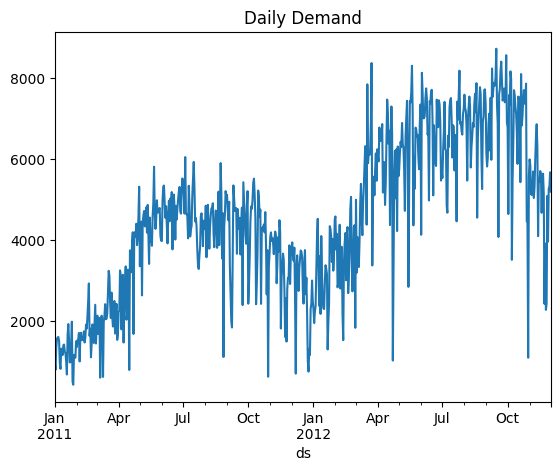

In [71]:
df_temp["y"].plot(title = "Daily Demand")
plt.show()
# There are some spikes (up and down)

## Monthly plot


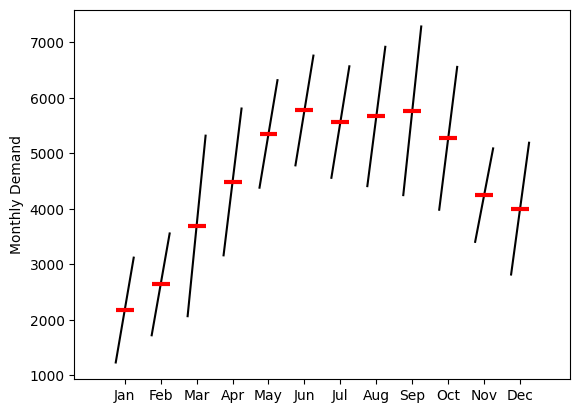

In [72]:
month_plot(df_temp["y"].resample("ME").mean(), ylabel="Monthly Demand")
plt.show()

## Quarterly plot

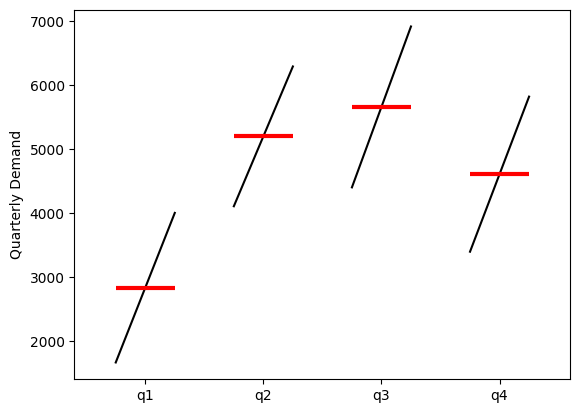

In [73]:
quarter_plot(df_temp["y"].resample("QE").mean(), ylabel="Quarterly Demand")
plt.show()

## Seasonal decomposition

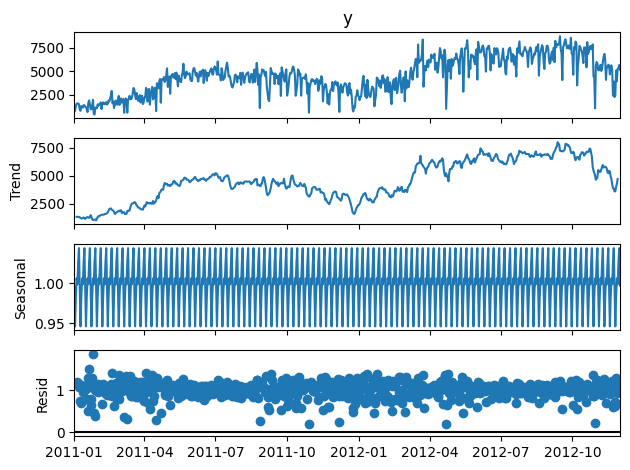

In [74]:
# plot seasonal decomposition
decomposition = seasonal_decompose(
    df_temp["y"],
    model = "mul",
    period = 7 # here we had used 365 before. But here we do not have 2 cycles!
    )

fig = decomposition.plot()
plt.show()
# We cannot get too much info from the plots

## Auto-correlation (correlation between daily data & lags)

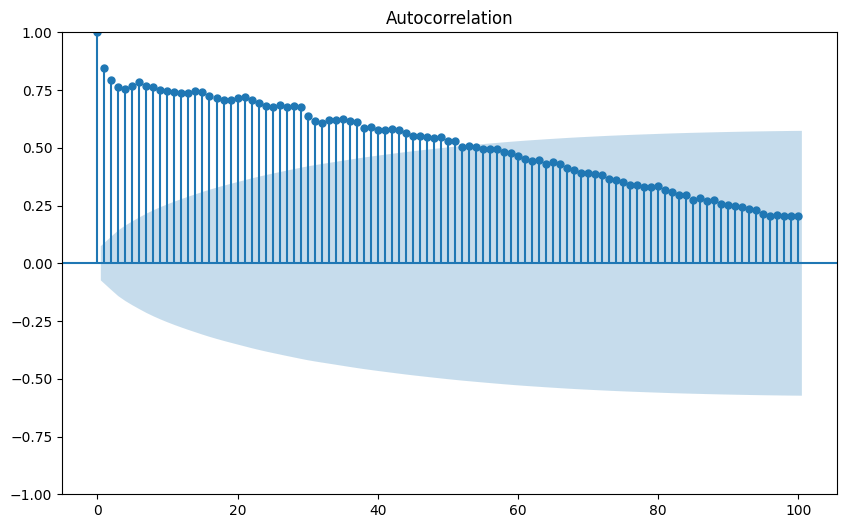

In [75]:
# Plot the autocorrelation (ACF)
fig, ax = plt.subplots(figsize = (10, 6))
plot_acf(df_temp["y"], lags = 100, ax = ax)
plt.show()


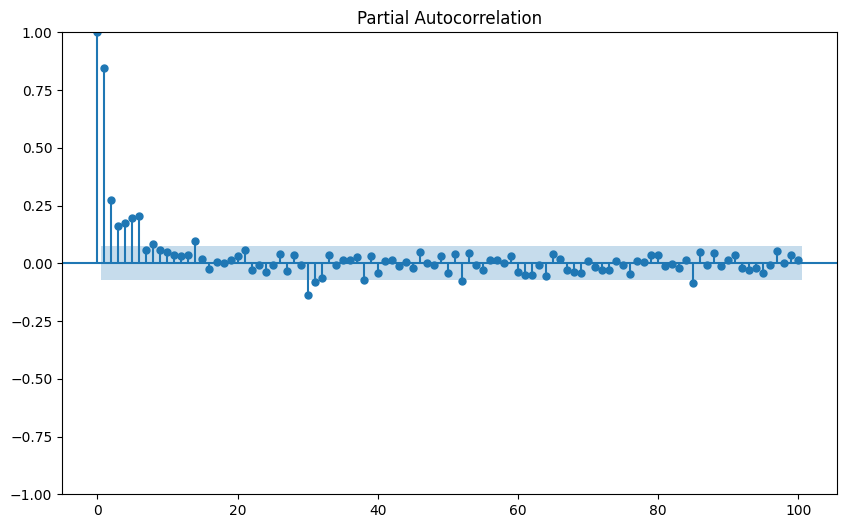

In [76]:
# Plot the partial autocorrelation (PACF)
fig, ax = plt.subplots(figsize = (10, 6))
plot_pacf(df_temp["y"], lags = 100, ax = ax)
plt.show()


# Dynamic holidays in Prophet

In [77]:
# Check the holidays in df
df[df.holiday == 1].ds

# This data is from Washington DC.
# Lets ask Chat GPT abou these days.

,ds
16,2011-01-17
51,2011-02-21
104,2011-04-15
149,2011-05-30
184,2011-07-04
247,2011-09-05
282,2011-10-10
314,2011-11-11
327,2011-11-24
359,2011-12-26


*	2011-01-17 (Martin Luther King Jr. Day)
*	2011-02-21 (Presidents' Day)
*	2011-04-15 (Emancipation Day observed in D.C.)
*	2011-05-30 (Memorial Day)
*	2011-07-04 (Independence Day)
*	2011-09-05 (Labor Day)
*	2011-10-10 (Columbus Day)
*	2011-11-11 (Veterans Day)
*	2011-11-24 (Thanksgiving Day)
*	2011-12-26 (Christmas Day observed, since Dec. 25 was a Sunday)
*	2012-01-02 (New Year's Day observed, since Jan. 1 was a Sunday)
*	2012-01-16 (Martin Luther King Jr. Day)
*	2012-02-20 (Presidents' Day)
*	2012-04-16 (Emancipation Day observed in D.C.)
*	2012-05-28 (Memorial Day)
*	2012-07-04 (Independence Day)
*	2012-09-03 (Labor Day)
*	2012-10-08 (Columbus Day)
*	2012-11-12 (Veterans Day observed, since Nov. 11 was a Sunday)
*	2012-11-22 (Thanksgiving Day)

## Prepare dataframe for the holidays

This holiday dataframe will be feeded to Prophet


In [78]:
# Holidays

# generic holidays from df
gen_holidays = pd.DataFrame({
    "holiday": "gen_holi",
    "ds": df[df.holiday == 1].ds,
    "lower_window": -2,
    "upper_window": 2
    })

# christmas holiday
xmas = pd.DataFrame({
    "holiday": "christmas",
    "ds": pd.to_datetime(["2011-12-24", "2012-12-24"]),
    "lower_window": -3,
    "upper_window": 3
    })

# new year eve
nye = pd.DataFrame({
    "holiday": "new_years",
    "ds": pd.to_datetime(["2011-12-31", "2012-12-31"]),
    "lower_window": -3,
    "upper_window": 3
    })

# easter
easter = pd.DataFrame({
    "holiday": "easter",
    "ds": pd.to_datetime(["2011-04-24", "2012-04-08"]),
    "lower_window": -3,
    "upper_window": 3
    })

In [79]:
# Combine all the holidays
holidays = pd.concat([gen_holidays, xmas, nye, easter])
holidays

,holiday,ds,lower_window,upper_window
16,gen_holi,2011-01-17,-2,2
51,gen_holi,2011-02-21,-2,2
104,gen_holi,2011-04-15,-2,2
149,gen_holi,2011-05-30,-2,2
184,gen_holi,2011-07-04,-2,2
247,gen_holi,2011-09-05,-2,2
282,gen_holi,2011-10-10,-2,2
314,gen_holi,2011-11-11,-2,2
327,gen_holi,2011-11-24,-2,2
359,gen_holi,2011-12-26,-2,2


# Feature Engineering

Assumig that people plan the future
  * checking the weather on the a few days before.

In [80]:
# creating lagged values for temp and atemp
for lag in [1, 3, 5, 7]:
  df[f"temp_lag_{lag}"] = df["temp"].shift(lag)
  df[f"atemp_lag_{lag}"] = df["atemp"].shift(lag)

df.head()

,ds,holiday,workingday,weathersit,temp,atemp,hum,windspeed,y,weathersit_2,weathersit_3,temp_lag_1,atemp_lag_1,temp_lag_3,atemp_lag_3,temp_lag_5,atemp_lag_5,temp_lag_7,atemp_lag_7
0,2011-01-01,0,0,2,0.344167,0.363625,0.805833,0.160446,985,True,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2011-01-02,0,0,2,0.363478,0.353739,0.696087,0.248539,801,True,False,0.344167,0.363625,NaN,NaN,NaN,NaN,NaN,NaN
2,2011-01-03,0,1,1,0.196364,0.189405,0.437273,0.248309,1349,False,False,0.363478,0.353739,NaN,NaN,NaN,NaN,NaN,NaN
3,2011-01-04,0,1,1,0.200000,0.212122,0.590435,0.160296,1562,False,False,0.196364,0.189405,0.344167,0.363625,NaN,NaN,NaN,NaN
4,2011-01-05,0,1,1,0.226957,0.229270,0.436957,0.186900,1600,False,False,0.200000,0.212122,0.363478,0.353739,NaN,NaN,NaN,NaN


### Correlations between lagged values

In [81]:
# Correlation matrix between y and lagged values

# select the column names for correlation
columns_for_correlation = ["y"] + [f"{var}_lag_{lag}" for var in ["temp", "atemp"] for lag in [1, 3, 5, 7]]
columns_for_correlation

['y',
 'temp_lag_1',
 'temp_lag_3',
 'temp_lag_5',
 'temp_lag_7',
 'atemp_lag_1',
 'atemp_lag_3',
 'atemp_lag_5',
 'atemp_lag_7']

In [82]:
df[columns_for_correlation].corr()
# Below correlations for the lag_1, lag_3, lag_5 and lag_7 seem to be almost same.
# So we will use only one of them.

,y,temp_lag_1,temp_lag_3,temp_lag_5,temp_lag_7,atemp_lag_1,atemp_lag_3,atemp_lag_5,atemp_lag_7
y,1.000000,0.589880,0.580211,0.587960,0.593870,0.585980,0.575220,0.585258,0.589737
temp_lag_1,0.589880,1.000000,0.892245,0.861173,0.864545,0.991526,0.882663,0.847990,0.852673
temp_lag_3,0.580211,0.892245,1.000000,0.891829,0.860613,0.877489,0.991519,0.882187,0.847451
temp_lag_5,0.587960,0.861173,0.891829,1.000000,0.891432,0.848465,0.877082,0.991490,0.881814
temp_lag_7,0.593870,0.864545,0.860613,0.891432,1.000000,0.853113,0.847940,0.876584,0.991475
atemp_lag_1,0.585980,0.991526,0.877489,0.848465,0.853113,1.000000,0.869430,0.836607,0.842372
atemp_lag_3,0.575220,0.882663,0.991519,0.877082,0.847940,0.869430,1.000000,0.868989,0.836076
atemp_lag_5,0.585258,0.847990,0.882187,0.991490,0.876584,0.836607,0.868989,1.000000,0.868539
atemp_lag_7,0.589737,0.852673,0.847451,0.881814,0.991475,0.842372,0.836076,0.868539,1.000000


In [83]:
# Remove the lagged values but the temp_lag_1
df = df.iloc[:, :-7] # all the rows, all the columns except the last 7 columns!
df

,ds,holiday,workingday,weathersit,temp,atemp,hum,windspeed,y,weathersit_2,weathersit_3,temp_lag_1
0,2011-01-01,0,0,2,0.344167,0.363625,0.805833,0.160446,985,True,False,NaN
1,2011-01-02,0,0,2,0.363478,0.353739,0.696087,0.248539,801,True,False,0.344167
2,2011-01-03,0,1,1,0.196364,0.189405,0.437273,0.248309,1349,False,False,0.363478
3,2011-01-04,0,1,1,0.200000,0.212122,0.590435,0.160296,1562,False,False,0.196364
4,2011-01-05,0,1,1,0.226957,0.229270,0.436957,0.186900,1600,False,False,0.200000
...,...,...,...,...,...,...,...,...,...,...,...,...
696,2012-11-27,0,1,2,0.291667,0.281558,0.786667,0.237562,3959,True,False,0.313333
697,2012-11-28,0,1,1,0.296667,0.289762,0.506250,0.210821,5260,False,False,0.291667
698,2012-11-29,0,1,1,0.280870,0.298422,0.555652,0.115522,5323,False,False,0.296667
699,2012-11-30,0,1,1,0.298333,0.323867,0.649583,0.058471,5668,False,False,0.280870


# Prophet Model Parameters

https://chatgpt.com/share/67da97d3-1d84-8008-9521-b6e73e4ae99a

## Main Prophet Model parameters

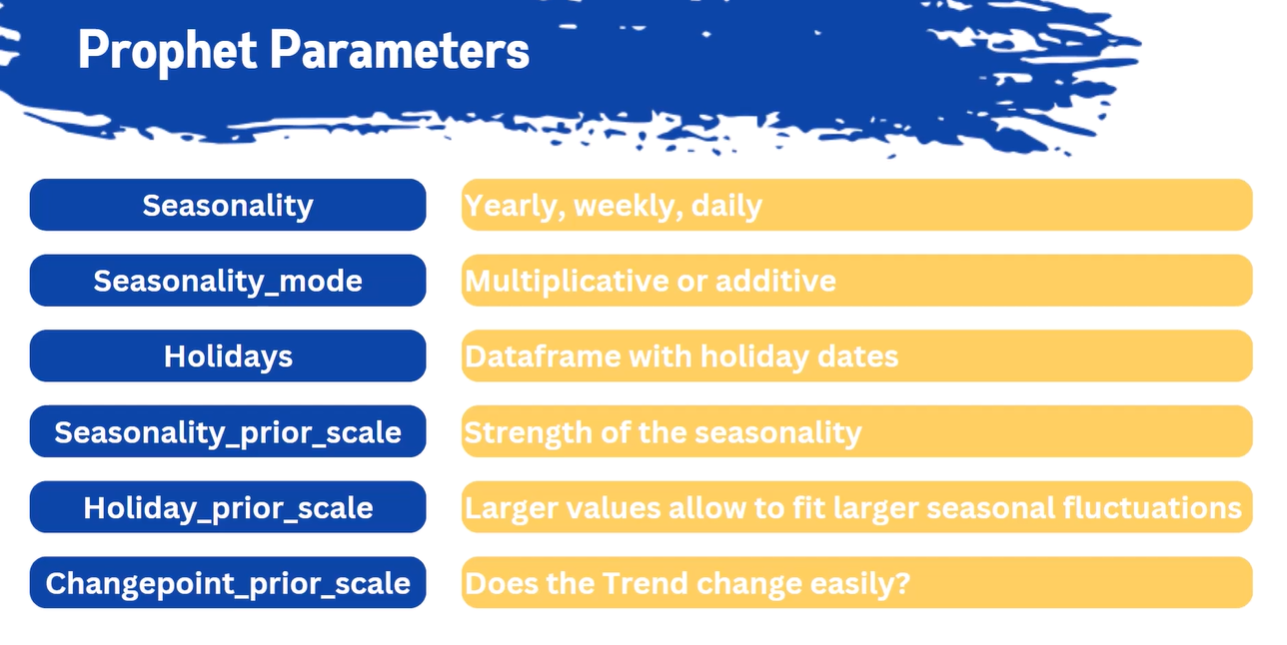

In [84]:
# let

## Prophet Model

In [85]:
# drop any NA
df = df.dropna()
df.columns

Index(['ds', 'holiday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum',
       'windspeed', 'y', 'weathersit_2', 'weathersit_3', 'temp_lag_1'],
      dtype='object')

In [86]:
# Generally m is used in Prophet models.

# Create Prophet model with parameteters
m = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    holidays = holidays,
    seasonality_mode = "multiplicative",
    seasonality_prior_scale=10,
    holidays_prior_scale=10,
    changepoint_prior_scale=0.05)

# add regressors (other variables that (we think) effect y variable)
m.add_regressor("workingday")
m.add_regressor("temp")
m.add_regressor("atemp")
m.add_regressor("hum")
m.add_regressor("windspeed")
m.add_regressor("weathersit_2")
m.add_regressor("weathersit_3")
m.add_regressor("temp_lag_1")
m.fit(df)




INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmplu1uk3nf/ndtsq4my.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplu1uk3nf/c78xei5r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73767', 'data', 'file=/tmp/tmplu1uk3nf/ndtsq4my.json', 'init=/tmp/tmplu1uk3nf/c78xei5r.json', 'output', 'file=/tmp/tmplu1uk3nf/prophet_modelpeoztbbq/prophet_model-20250320103925.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:39:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:39:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


## Model Regressor coefficients

In [87]:
# print regressor coefficients
regressor_coefficients(m)

,regressor,regressor_mode,center,coef_lower,coef,coef_upper
0,workingday,multiplicative,0.000000,0.451295,0.451295,0.451295
1,temp,multiplicative,0.502959,1.236038,1.236038,1.236038
2,atemp,multiplicative,0.481015,0.398934,0.398934,0.398934
3,hum,multiplicative,0.625459,-0.452458,-0.452458,-0.452458
4,windspeed,multiplicative,0.190577,-0.601621,-0.601621,-0.601621
5,weathersit_2,multiplicative,0.000000,-0.115314,-0.115314,-0.115314
6,weathersit_3,multiplicative,0.000000,-0.448652,-0.448652,-0.448652
7,temp_lag_1,multiplicative,0.503024,-0.637862,-0.637862,-0.637862


## Cross-Validation

In [88]:
print(f"Number of the rows for cross validation: {df.shape[0] - 180}")

Number of the rows for cross validation: 520


In [89]:
df_cv = cross_validation(
    model = m,
    period = "15 days",
    initial = "521 days",
    horizon = "30 days", # test data length. We will predict for the next 15 days.
    parallel = "processes")

df_cv.head()

INFO:prophet:Making 10 forecasts with cutoffs between 2012-06-19 00:00:00 and 2012-11-01 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ae0366b5e50>
DEBUG:cmdstanpy:input tempfile: /tmp/tmplu1uk3nf/b5uk0gcj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplu1uk3nf/69ex35y9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplu1uk3nf/gince0mh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63972', 'data', 'file=/tmp/tmplu1uk3nf/b5uk0gcj.json', 'init=/tmp/tmplu1uk3nf/gince0mh.json', 'output', 'file=/tmp/tmplu1uk3nf/prophet_modeljpdj3o6z/prophet_model-20250320103926.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:39:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplu1uk3nf/l5ybn0ka.json
DE

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2012-06-20,8231.573980,7549.252351,8886.771596,6211,2012-06-19
1,2012-06-21,8527.317885,7845.195803,9208.362752,5905,2012-06-19
2,2012-06-22,8167.335441,7500.666510,8888.531295,5823,2012-06-19
3,2012-06-23,7747.285158,7062.602954,8447.544124,7458,2012-06-19
4,2012-06-24,7898.757694,7237.060801,8608.632034,6891,2012-06-19


## Performance metrics

### cross validation parameters

In [90]:
df_cv.head()
# ds: the day that we got the forecast for.
# cutoff: when the forecast is done.
# y: what actually happened
# yhat, yhat_lower and yhat_upper are the predictions.

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2012-06-20,8231.573980,7549.252351,8886.771596,6211,2012-06-19
1,2012-06-21,8527.317885,7845.195803,9208.362752,5905,2012-06-19
2,2012-06-22,8167.335441,7500.666510,8888.531295,5823,2012-06-19
3,2012-06-23,7747.285158,7062.602954,8447.544124,7458,2012-06-19
4,2012-06-24,7898.757694,7237.060801,8608.632034,6891,2012-06-19


### print the performance metrics using performance_metrics

In [91]:
# print the performance metrics using performance_metrics
df_p = performance_metrics(df_cv)
df_p

# we will focus on rmse and mape


,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,3 days,1.557674e+06,1248.068262,967.303218,0.169121,0.109646,0.161084,0.600000
1,4 days,1.381632e+06,1175.428228,899.135005,0.150445,0.108166,0.146093,0.633333
2,5 days,1.451532e+06,1204.795274,940.559393,0.153677,0.102198,0.149026,0.533333
3,6 days,1.135152e+06,1065.435014,838.233987,0.131065,0.086750,0.132160,0.566667
4,7 days,1.215827e+06,1102.645662,853.607550,0.129333,0.086750,0.133729,0.566667
5,8 days,9.519409e+05,975.674588,738.231621,0.103446,0.074152,0.111464,0.633333
6,9 days,8.979655e+05,947.610429,723.573172,0.101421,0.081998,0.107928,0.600000
7,10 days,1.373870e+06,1172.122167,859.487168,0.124763,0.089815,0.127301,0.533333
8,11 days,1.483034e+06,1217.798828,895.341305,0.133952,0.097349,0.134370,0.566667
9,12 days,1.941069e+06,1393.222637,1086.079624,0.171269,0.117966,0.174827,0.466667


In [92]:
df_p.mean()

,0
horizon,16 days 12:00:00
mse,1674679.847498
rmse,1282.262761
mae,995.820745
mape,0.179167
mdape,0.109036
smape,0.167897
coverage,0.522619


In [93]:
rmse = round(performance_metrics(df_cv)["rmse"].mean(), 0)
mape = round(performance_metrics(df_cv)["mape"].mean() * 100, 2 ) # this is percentage
print(f"RMSE: {rmse} and MAPE (Mean Absolute Percentage Error): {mape} %")

# here mape is very big

RMSE: 1282.0 and MAPE (Mean Absolute Percentage Error): 17.92 %


### mape is very big

/usr/local/lib/python3.11/dist-packages/prophet/plot.py:546: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])
/usr/local/lib/python3.11/dist-packages/prophet/plot.py:547: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])


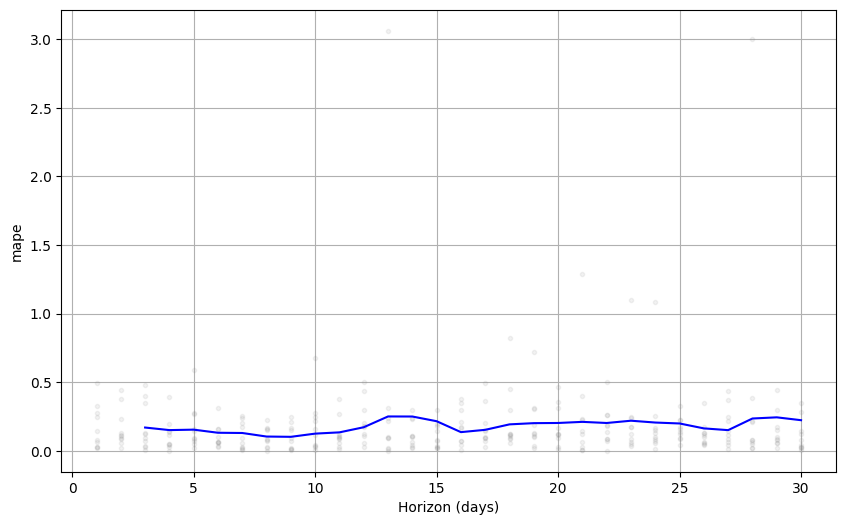

In [94]:
# Plotting the metrics over time
fig = plot_cross_validation_metric(df_cv, metric='mape')

# below we can see some outliers around 120 (in the y axis)

# lets check the data set and explore

In [95]:
# lets check the performance metrics again
performance_metrics(df_cv)

# 9, 10, 11, 24, 25, 26 rows, there is way too much difference!!!

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,3 days,1.557674e+06,1248.068262,967.303218,0.169121,0.109646,0.161084,0.600000
1,4 days,1.381632e+06,1175.428228,899.135005,0.150445,0.108166,0.146093,0.633333
2,5 days,1.451532e+06,1204.795274,940.559393,0.153677,0.102198,0.149026,0.533333
3,6 days,1.135152e+06,1065.435014,838.233987,0.131065,0.086750,0.132160,0.566667
4,7 days,1.215827e+06,1102.645662,853.607550,0.129333,0.086750,0.133729,0.566667
5,8 days,9.519409e+05,975.674588,738.231621,0.103446,0.074152,0.111464,0.633333
6,9 days,8.979655e+05,947.610429,723.573172,0.101421,0.081998,0.107928,0.600000
7,10 days,1.373870e+06,1172.122167,859.487168,0.124763,0.089815,0.127301,0.533333
8,11 days,1.483034e+06,1217.798828,895.341305,0.133952,0.097349,0.134370,0.566667
9,12 days,1.941069e+06,1393.222637,1086.079624,0.171269,0.117966,0.174827,0.466667


### Explore the deviated values

9, 10, 11, 24, 25, 26 rows, there is way too much difference!!!

In [96]:
df_cv["deviation"] = df_cv["yhat"] - df_cv["y"]
df_cv["deviation_%"] = ((df_cv["yhat"] / df_cv["y"]) - 1) * 100

In [97]:
# days with the highest deviation
df_cv.sort_values(by = "deviation_%", ascending = False).head(20)

# so there is something on the 2012-10-29 and 2012-10-30 dates

,ds,yhat,yhat_lower,yhat_upper,y,cutoff,deviation,deviation_%
252,2012-10-30,4451.690714,3681.789563,5252.891352,1096,2012-10-17,3355.690714,306.176160
237,2012-10-30,4387.983825,3596.558434,5190.595314,1096,2012-10-02,3291.983825,300.363488
290,2012-11-22,5548.264400,4754.428691,6336.248587,2425,2012-11-01,3123.264400,128.794408
292,2012-11-24,4785.344498,3974.397548,5579.325105,2277,2012-11-01,2508.344498,110.160057
293,2012-11-25,5055.833965,4236.042879,5833.001483,2424,2012-11-01,2631.833965,108.574008
17,2012-07-07,8800.670419,8079.164131,9474.583943,4840,2012-06-19,3960.670419,81.832033
18,2012-07-08,8024.794869,7361.427445,8752.414334,4672,2012-06-19,3352.794869,71.763589
9,2012-06-29,9157.661097,8489.875556,9843.028473,5463,2012-06-19,3694.661097,67.630626
214,2012-10-07,5583.223607,4820.777184,6310.368580,3510,2012-10-02,2073.223607,59.066200
11,2012-07-01,8315.727716,7616.378729,9007.250529,5531,2012-06-19,2784.727716,50.347635


In [98]:
# lets check 2012-10-29 and 2012-10-30 dates

In [99]:
exp_date = "2012-10-29"
print(df[df.ds == exp_date]) # y is --> 22
# However, if we check the data 22 is way too low!
# What happened on the 2012-10-29? Lets ask ChatGPT!



            ds  holiday  workingday  weathersit  temp   atemp   hum  \
667 2012-10-29        0           1           3  0.44  0.4394  0.88   

     windspeed     y  weathersit_2  weathersit_3  temp_lag_1  
667     0.3582  4459         False          True      0.4775  


### on the 2012-10-29 in Washington DC

What happened on the 29th of October 2012 in Washington DC?


On October 29, 2012, Washington, D.C. was impacted by Hurricane Sandy, one of the most powerful and destructive hurricanes in U.S. history. While the storm's worst effects were felt in New Jersey and New York, it still brought heavy rain, strong winds, and flooding to the D.C. area.

Key Impacts in Washington, D.C.:
Government and School Closures: The federal government, as well as schools and public transportation, were shut down due to the storm.
Power Outages: Thousands of residents in the D.C. metro area lost power as trees and power lines were knocked down.
Flooding and Wind Damage: Coastal areas along the Potomac River experienced flooding, and high winds caused property damage.
Metro Service Suspension: The Washington Metro system shut down in preparation for the storm.
Flight Cancellations: Airports in the region, including Reagan National and Dulles, canceled hundreds of flights.
While D.C. was not in the direct path of the storm, its effects were significant enough to disrupt daily life in the nation's capital. The worst devastation, however, occurred in New York and New Jersey, where Sandy caused massive destruction and loss of life.


In [100]:
# lets replace this outlier data with something.
# 2012-10-29 and 2012-10-30 --> 2012-10-28
# Lets do this replacement on the "Preparing Data" phase!


## Parameter Tuning

### Parameter grid

In [101]:
# Define the parameter grid to search

param_grid = {
    'changepoint_prior_scale': [0.05, 0.5],
    "seasonality_prior_scale": [10, 20],
    "holidays_prior_scale": [10, 20],
    "seasonality_mode": ["additive", "multiplicative"]
}



### Combinations of the parameters

In [102]:
all_params = list(ParameterGrid(param_grid))
all_params

[{'changepoint_prior_scale': 0.05,
  'holidays_prior_scale': 10,
  'seasonality_mode': 'additive',
  'seasonality_prior_scale': 10},
 {'changepoint_prior_scale': 0.05,
  'holidays_prior_scale': 10,
  'seasonality_mode': 'additive',
  'seasonality_prior_scale': 20},
 {'changepoint_prior_scale': 0.05,
  'holidays_prior_scale': 10,
  'seasonality_mode': 'multiplicative',
  'seasonality_prior_scale': 10},
 {'changepoint_prior_scale': 0.05,
  'holidays_prior_scale': 10,
  'seasonality_mode': 'multiplicative',
  'seasonality_prior_scale': 20},
 {'changepoint_prior_scale': 0.05,
  'holidays_prior_scale': 20,
  'seasonality_mode': 'additive',
  'seasonality_prior_scale': 10},
 {'changepoint_prior_scale': 0.05,
  'holidays_prior_scale': 20,
  'seasonality_mode': 'additive',
  'seasonality_prior_scale': 20},
 {'changepoint_prior_scale': 0.05,
  'holidays_prior_scale': 20,
  'seasonality_mode': 'multiplicative',
  'seasonality_prior_scale': 10},
 {'changepoint_prior_scale': 0.05,
  'holidays_prio

### Results for the parameter combinations

In [103]:
# took around 5 minutes.

tuning_results = []

# Build a pipeline for the parameter tuning
for params in all_params:
  # build the model
  m = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    holidays = holidays,
    **params)
  # add regressors (other variables that (we think) effect y variable)
  m.add_regressor("workingday")
  m.add_regressor("temp")
  m.add_regressor("atemp")
  m.add_regressor("hum")
  m.add_regressor("windspeed")
  m.add_regressor("weathersit_2")
  m.add_regressor("weathersit_3")
  m.add_regressor("temp_lag_1")
  m.fit(df)

  # cross validation
  df_cv = cross_validation(
    model = m,
    period = "15 days",
    initial = "521 days",
    horizon = "30 days", # test data length. We will predict for the next 15 days.
    parallel = "processes")

  # Compute and store the error
  rmse = performance_metrics(df_cv)["rmse"].mean()
  tuning_results.append(rmse)



INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmplu1uk3nf/027o_ssn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplu1uk3nf/7es23137.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80895', 'data', 'file=/tmp/tmplu1uk3nf/027o_ssn.json', 'init=/tmp/tmplu1uk3nf/7es23137.json', 'output', 'file=/tmp/tmplu1uk3nf/prophet_modelzd7vjhgc/prophet_model-20250320103935.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:39:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:39:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2012-06-19 00:00:00 and 2012-11-01 00:00:00
INFO:prophet:Applying in parallel with <conc

### Parameter tuning outcome

In [104]:
outcome = pd.DataFrame(all_params)
outcome["tuning_results"] = tuning_results
outcome



,changepoint_prior_scale,holidays_prior_scale,seasonality_mode,seasonality_prior_scale,tuning_results
0,0.05,10,additive,10,1034.577493
1,0.05,10,additive,20,1037.193885
2,0.05,10,multiplicative,10,1282.262761
3,0.05,10,multiplicative,20,1291.749850
4,0.05,20,additive,10,1035.681381
5,0.05,20,additive,20,1034.828224
6,0.05,20,multiplicative,10,1285.429614
7,0.05,20,multiplicative,20,1289.163643
8,0.50,10,additive,10,1185.463589
9,0.50,10,additive,20,1182.622121


In [105]:
# Fetch the best parameters
#best_params = outcome.loc[outcome["tuning_results"].idxmin()].to_dict()
#best_params
best_params = all_params[tuning_results.index(min(tuning_results))]

## Predict the future

### Read Training and Test Data

Again

In [129]:
df_train = pd.read_csv(DRIVE_DATASET_PATH + "Daily Bike Sharing training.csv")
df_future = pd.read_csv(DRIVE_DATASET_PATH + "Daily Bike Sharing future.csv")
df = pd.concat([df_train, df_future])
df.reset_index(drop = True, inplace = True)
df.tail()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
726,727,12/27/2012,1,1,12,0,4,1,2,0.254167,0.226642,0.652917,0.350133,NaN,NaN,NaN
727,728,12/28/2012,1,1,12,0,5,1,2,0.253333,0.255046,0.590000,0.155471,NaN,NaN,NaN
728,729,12/29/2012,1,1,12,0,6,0,2,0.253333,0.242400,0.752917,0.124383,NaN,NaN,NaN
729,730,12/30/2012,1,1,12,0,0,0,1,0.255833,0.231700,0.483333,0.350754,NaN,NaN,NaN
730,731,12/31/2012,1,1,12,0,1,1,2,0.215833,0.223487,0.577500,0.154846,NaN,NaN,NaN


### Prepare data

I have copied the things above.

In [130]:
# rename columns
df = df.rename(columns = {
    "cnt": "y",
    "dteday": "ds"
    })

# Change ds into YYYY-mm-dd
df["ds"] = pd.to_datetime(df["ds"], format="%m/%d/%Y")

df.head()

,instant,ds,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,y
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331.0,654.0,985.0
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131.0,670.0,801.0
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120.0,1229.0,1349.0
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108.0,1454.0,1562.0
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82.0,1518.0,1600.0


In [131]:
# Prepare the weather situation, make it categorical

weather_sit = pd.get_dummies(df["weathersit"], drop_first = True)
weather_sit

# concat weather_sit to df
df = pd.concat([df, weather_sit], axis = 1)
df.head()

,instant,ds,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,y,2,3
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331.0,654.0,985.0,True,False
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131.0,670.0,801.0,True,False
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120.0,1229.0,1349.0,False,False
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108.0,1454.0,1562.0,False,False
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82.0,1518.0,1600.0,False,False


In [132]:
# rename new columns named, 2 and 3
df = df.rename(columns = {
    2: "weathersit_2",
    3: "weathersit_3"
    })
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   instant       731 non-null    int64         
 1   ds            731 non-null    datetime64[ns]
 2   season        731 non-null    int64         
 3   yr            731 non-null    int64         
 4   mnth          731 non-null    int64         
 5   holiday       731 non-null    int64         
 6   weekday       731 non-null    int64         
 7   workingday    731 non-null    int64         
 8   weathersit    731 non-null    int64         
 9   temp          731 non-null    float64       
 10  atemp         731 non-null    float64       
 11  hum           731 non-null    float64       
 12  windspeed     731 non-null    float64       
 13  casual        701 non-null    float64       
 14  registered    701 non-null    float64       
 15  y             701 non-null    float64   

In [133]:
# Drop variables that are not needed
df.drop(
    columns = ["instant", "season", "yr", "mnth", "weekday", "casual", "registered"],
        axis = 1,
        inplace = True)
df.head()


,ds,holiday,workingday,weathersit,temp,atemp,hum,windspeed,y,weathersit_2,weathersit_3
0,2011-01-01,0,0,2,0.344167,0.363625,0.805833,0.160446,985.0,True,False
1,2011-01-02,0,0,2,0.363478,0.353739,0.696087,0.248539,801.0,True,False
2,2011-01-03,0,1,1,0.196364,0.189405,0.437273,0.248309,1349.0,False,False
3,2011-01-04,0,1,1,0.200000,0.212122,0.590435,0.160296,1562.0,False,False
4,2011-01-05,0,1,1,0.226957,0.229270,0.436957,0.186900,1600.0,False,False


In [134]:
to_replace = df.loc[df.ds == "2012-10-28"].y.values[0]
df.loc[df.ds == "2012-10-29", "y"] = to_replace
df.loc[df.ds == "2012-10-28", "y"] = to_replace


In [135]:
# Holidays

# generic holidays from df
gen_holidays = pd.DataFrame({
    "holiday": "gen_holi",
    "ds": df[df.holiday == 1].ds,
    "lower_window": -2,
    "upper_window": 2
    })

# christmas holiday
xmas = pd.DataFrame({
    "holiday": "christmas",
    "ds": pd.to_datetime(["2011-12-24", "2012-12-24"]),
    "lower_window": -3,
    "upper_window": 3
    })

# new year eve
nye = pd.DataFrame({
    "holiday": "new_years",
    "ds": pd.to_datetime(["2011-12-31", "2012-12-31"]),
    "lower_window": -3,
    "upper_window": 3
    })

# easter
easter = pd.DataFrame({
    "holiday": "easter",
    "ds": pd.to_datetime(["2011-04-24", "2012-04-08"]),
    "lower_window": -3,
    "upper_window": 3
    })

In [136]:
# Combine all the holidays
holidays = pd.concat([gen_holidays, xmas, nye, easter])
holidays

,holiday,ds,lower_window,upper_window
16,gen_holi,2011-01-17,-2,2
51,gen_holi,2011-02-21,-2,2
104,gen_holi,2011-04-15,-2,2
149,gen_holi,2011-05-30,-2,2
184,gen_holi,2011-07-04,-2,2
247,gen_holi,2011-09-05,-2,2
282,gen_holi,2011-10-10,-2,2
314,gen_holi,2011-11-11,-2,2
327,gen_holi,2011-11-24,-2,2
359,gen_holi,2011-12-26,-2,2


In [137]:
# Below correlations for the lag_1, lag_3, lag_5 and lag_7 seem to be almost same.
# So we will use only one of them.
lag = 1
df[f"temp_lag_{lag}"] = df["temp"].shift(lag)
df

,ds,holiday,workingday,weathersit,temp,atemp,hum,windspeed,y,weathersit_2,weathersit_3,temp_lag_1
0,2011-01-01,0,0,2,0.344167,0.363625,0.805833,0.160446,985.0,True,False,NaN
1,2011-01-02,0,0,2,0.363478,0.353739,0.696087,0.248539,801.0,True,False,0.344167
2,2011-01-03,0,1,1,0.196364,0.189405,0.437273,0.248309,1349.0,False,False,0.363478
3,2011-01-04,0,1,1,0.200000,0.212122,0.590435,0.160296,1562.0,False,False,0.196364
4,2011-01-05,0,1,1,0.226957,0.229270,0.436957,0.186900,1600.0,False,False,0.200000
...,...,...,...,...,...,...,...,...,...,...,...,...
726,2012-12-27,0,1,2,0.254167,0.226642,0.652917,0.350133,NaN,True,False,0.243333
727,2012-12-28,0,1,2,0.253333,0.255046,0.590000,0.155471,NaN,True,False,0.254167
728,2012-12-29,0,0,2,0.253333,0.242400,0.752917,0.124383,NaN,True,False,0.253333
729,2012-12-30,0,0,1,0.255833,0.231700,0.483333,0.350754,NaN,False,False,0.253333


Index(['ds', 'holiday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum',
       'windspeed', 'y', 'weathersit_2', 'weathersit_3', 'temp_lag_1'],
      dtype='object')

### Tuned Prophet Model

In [138]:
# just training data
number_of_days_to_predict = 30
train = df.iloc[:-number_of_days_to_predict] # we will predict the next 30 days!

# drop any NA
train = train.dropna()
train.columns

Index(['ds', 'holiday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum',
       'windspeed', 'y', 'weathersit_2', 'weathersit_3', 'temp_lag_1'],
      dtype='object')

In [139]:
# Generally m is used in Prophet models.

# Create Prophet model with parameteters
m = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    holidays = holidays,
    **best_params)

# add regressors (other variables that (we think) effect y variable)
m.add_regressor("workingday")
m.add_regressor("temp")
m.add_regressor("atemp")
m.add_regressor("hum")
m.add_regressor("windspeed")
m.add_regressor("weathersit_2")
m.add_regressor("weathersit_3")
m.add_regressor("temp_lag_1")
m.fit(train)




INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmplu1uk3nf/tvsogdyu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplu1uk3nf/nmiweuqz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27513', 'data', 'file=/tmp/tmplu1uk3nf/tvsogdyu.json', 'init=/tmp/tmplu1uk3nf/nmiweuqz.json', 'output', 'file=/tmp/tmplu1uk3nf/prophet_modelf5fhcyiu/prophet_model-20250320110405.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:04:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:04:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


### Forecasting


In [142]:
# Future regressors
future_regressors = df.drop(columns = ["ds", "y"])
future_regressors = future_regressors.dropna()
future_regressors.reset_index(drop = True, inplace = True)
future_regressors

,holiday,workingday,weathersit,temp,atemp,hum,windspeed,weathersit_2,weathersit_3,temp_lag_1
0,0,0,2,0.363478,0.353739,0.696087,0.248539,True,False,0.344167
1,0,1,1,0.196364,0.189405,0.437273,0.248309,False,False,0.363478
2,0,1,1,0.200000,0.212122,0.590435,0.160296,False,False,0.196364
3,0,1,1,0.226957,0.229270,0.436957,0.186900,False,False,0.200000
4,0,1,1,0.204348,0.233209,0.518261,0.089565,False,False,0.226957
...,...,...,...,...,...,...,...,...,...,...
725,0,1,2,0.254167,0.226642,0.652917,0.350133,True,False,0.243333
726,0,1,2,0.253333,0.255046,0.590000,0.155471,True,False,0.254167
727,0,0,2,0.253333,0.242400,0.752917,0.124383,True,False,0.253333
728,0,0,1,0.255833,0.231700,0.483333,0.350754,False,False,0.253333


In [143]:
# Create a future data frame
future = m.make_future_dataframe(periods = 30)
future = pd.concat([future, future_regressors], axis = 1)


In [146]:
# make the forcast
forecast = m.predict(future)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,atemp,...,workingday,workingday_lower,workingday_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2011-01-02,2358.566096,-101.483459,1777.725334,2358.566096,2358.566096,-1523.483324,-1523.483324,-1523.483324,-180.168006,...,0.000000,0.000000,0.000000,-588.305012,-588.305012,-588.305012,0.0,0.0,0.0,835.082772
1,2011-01-03,2363.715808,-31.525712,1778.500978,2363.715808,2363.715808,-1533.330655,-1533.330655,-1533.330655,-412.794529,...,648.577792,648.577792,648.577792,-592.749656,-592.749656,-592.749656,0.0,0.0,0.0,830.385153
2,2011-01-04,2368.865520,442.180084,2163.500015,2368.865520,2368.865520,-1079.947009,-1079.947009,-1079.947009,-380.636992,...,648.577792,648.577792,648.577792,-595.775530,-595.775530,-595.775530,0.0,0.0,0.0,1288.918511
3,2011-01-05,2374.015233,834.912658,2584.251073,2374.015233,2374.015233,-706.713852,-706.713852,-706.713852,-356.362772,...,648.577792,648.577792,648.577792,-597.281719,-597.281719,-597.281719,0.0,0.0,0.0,1667.301380
4,2011-01-06,2379.164945,750.695990,2453.841264,2379.164945,2379.164945,-778.155315,-778.155315,-778.155315,-350.786836,...,648.577792,648.577792,648.577792,-597.206220,-597.206220,-597.206220,0.0,0.0,0.0,1601.009630


### Explore the forecast results

we will use Chat GPT for data visualisation


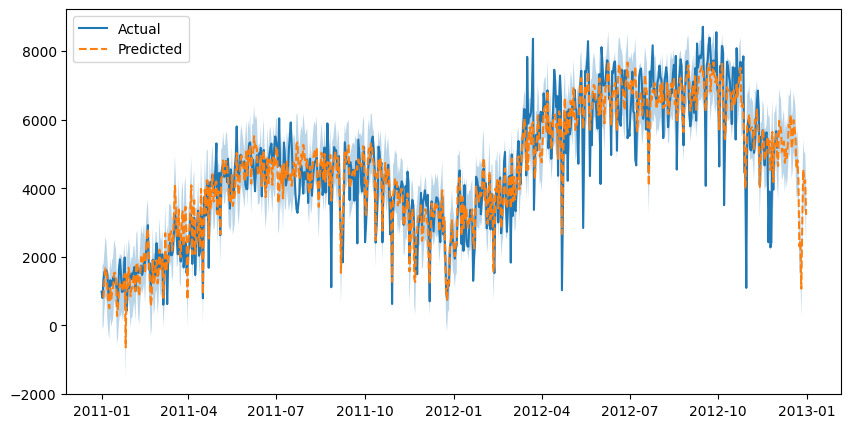

In [148]:
# plot time series data
plt.figure(figsize=(10, 5))
plt.plot(df['ds'], df['y'], label='Actual')
plt.plot(forecast['ds'], forecast['yhat'], label='Predicted', linestyle='dashed')
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], alpha=0.3)
plt.legend()
plt.show()


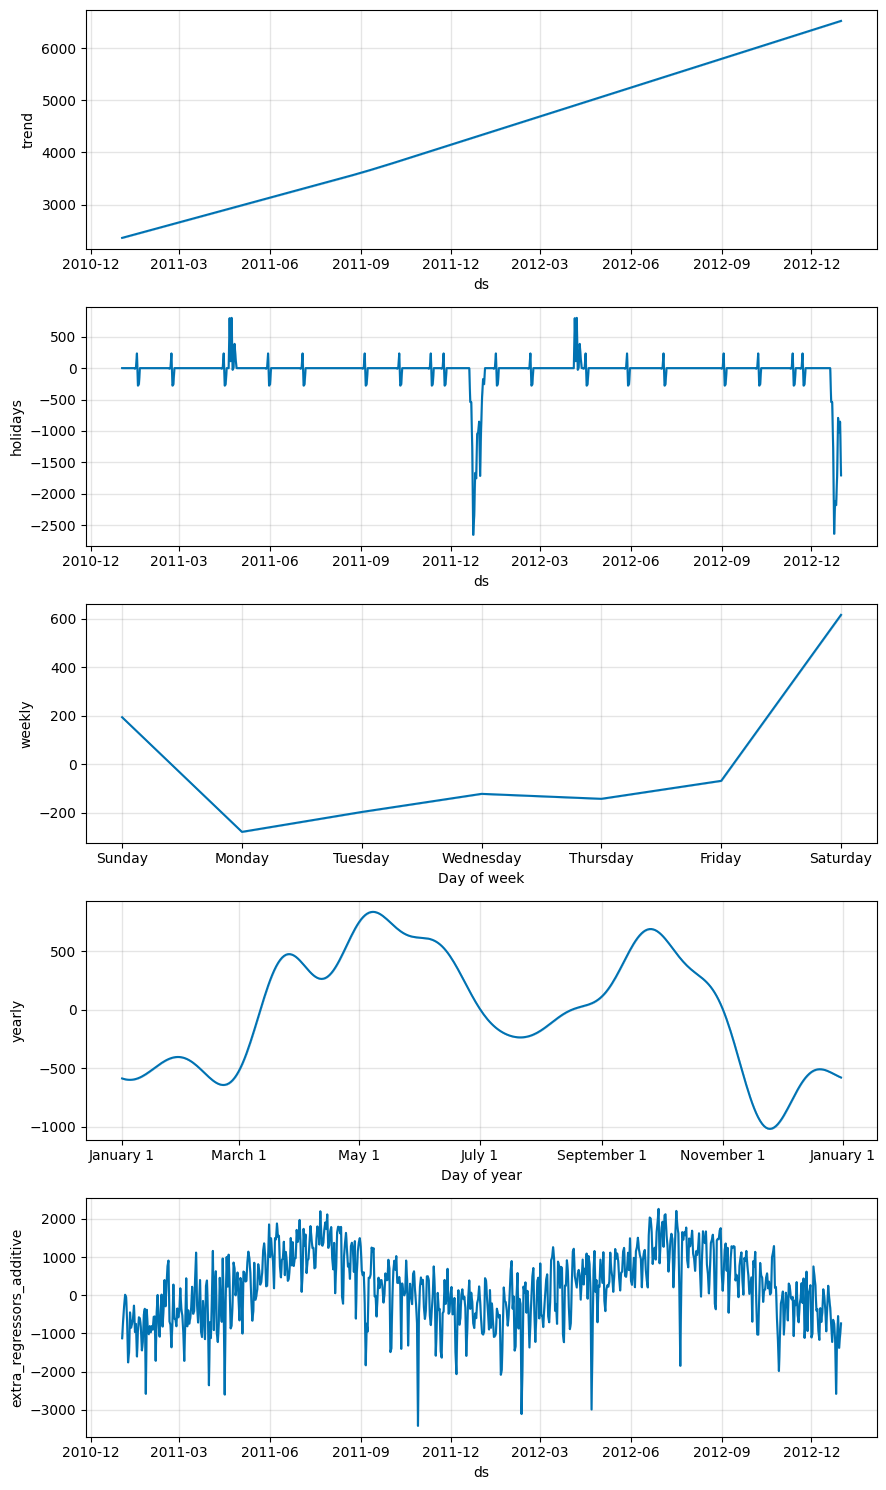

In [147]:
# plot components
fig = m.plot_components(forecast)
plt.show()


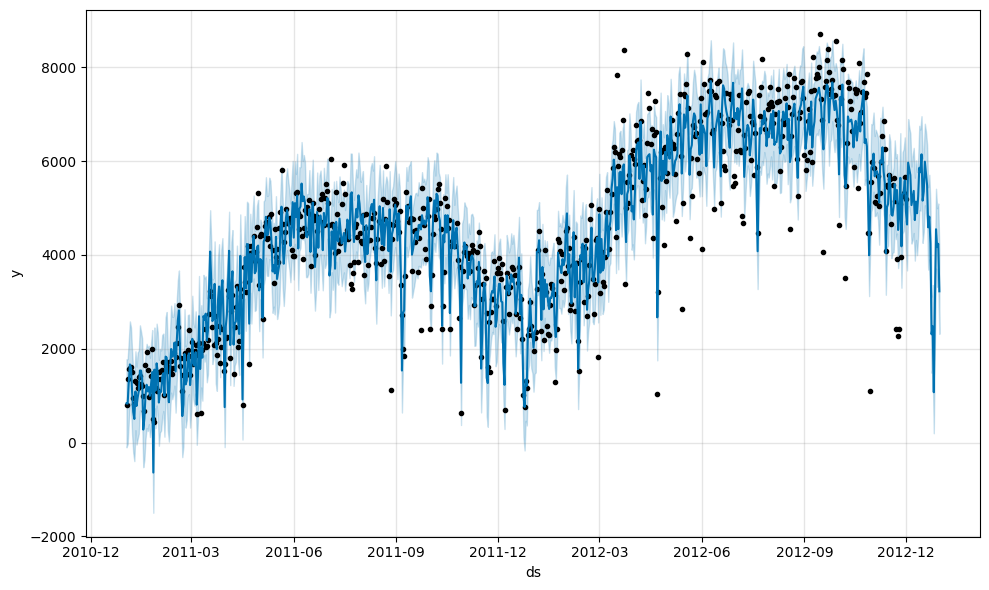

In [150]:
# plot the forecast
m.plot(forecast)
plt.show()

# dots are actual, lines are predictions

In [152]:
# interactive plot
from prophet.plot import plot_plotly
import plotly.offline as py

fig = plot_plotly(m, forecast)
py.iplot(fig)

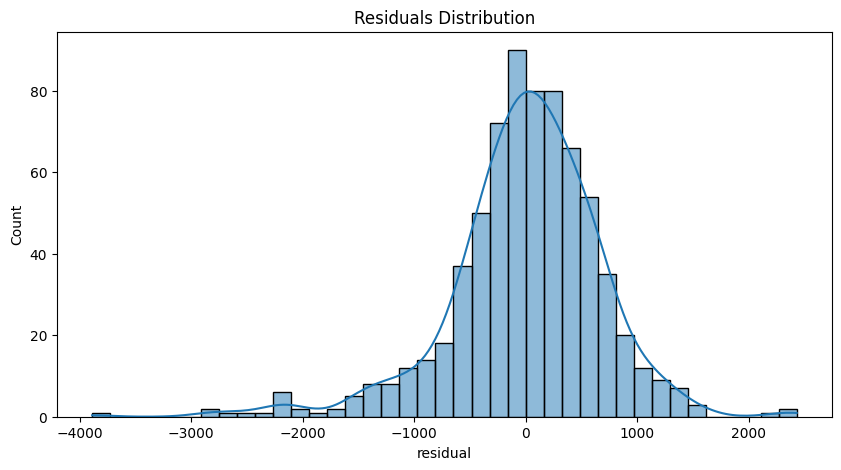

In [153]:
# Plot Forecast Errors (Residuals Analysis): How to interpret this?

import seaborn as sns

df_forecast = df.merge(forecast[['ds', 'yhat']], on='ds')
df_forecast['residual'] = df_forecast['y'] - df_forecast['yhat']

plt.figure(figsize=(10, 5))
sns.histplot(df_forecast['residual'], kde=True)
plt.title('Residuals Distribution')
plt.show()